# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [1]:
from thick_ptycho.simulation.config import SimulationConfig, ProbeType
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.forward_model.pwe.operators import BoundaryType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEIterativeLUSolver, PWEFullPinTSolver, MSForwardModelSolver
from matplotlib import pyplot as plt
import time

from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [2]:
# --- Probe configuration ---
probe_diameter =  5e-6# meters
probe_focus = -3e-6 # focal length [m]
wavelength = 0.635e-6        # meters (0.635 μm). Visible light
probe_type = ProbeType.AIRY_DISK
print(f"Probe options: {ProbeType.list()}")
# probe_angles=(np.linspace(-15,15,3))

Probe options: ['constant', 'gaussian', 'sinusoidal', 'complex_exp', 'dirichlet_test', 'neumann_test', 'airy_disk', 'disk', 'blurred_disk']


### Discretization Parameters and Spatial Limits

In [3]:
# Width Discretization (Pixels)
scan_points = 1
step_size_px = 100
pad_factor = 3  # Must be >= 1.0
# Overlap = N - (scan_points*step_size_px) = padding
# Overlap factor = (N - (scan_points*step_size_px)) / step_size_px
#                = (pad_factor*scan_points) - scan_points) = scan_points*(pad_factor - 1)
# N = int(pad_factor*scan_points*step_size_px)
solve_reduced_domain = False

# Thickness Discretization (Pixels)
points_per_wavelength = 8 
# Then:
#  - dz = wavelength / points_per_wavelength
#  - nz = int((zlims[1] - zlims[0]) / dz)
# Override by setting nz directly


# --- Simulation spatial dimensions (in meters) ---
spatial_limits = Limits(x=(0.0, 110e-6), # Sample width
                        z=(0.0, 40e-6), # Sample thickness
                        units="meters")


### Simulation Config

/home/dnz75396/thick_ptycho/thick_ptycho/simulation/config.py:143: RuntimeWarning: solve_reduced_domain=True has no effect when scan_points=1; using full domain.
  warnings.warn(
2025-11-12 17:25:30,410 - INFO - === Scan Summary (Continuous) ===
2025-11-12 17:25:30,413 - INFO -   Sample space (x-range): 1.100e-04 m
2025-11-12 17:25:30,414 - INFO -   Sample space (z-range): 4.000e-05 m
2025-11-12 17:25:30,417 - INFO -   Sample Pixels:          300
2025-11-12 17:25:30,419 - INFO -   Number of scan points:  1
2025-11-12 17:25:30,422 - INFO -   Steps in z:             503
2025-11-12 17:25:30,424 - INFO -   Solve reduced domain:   300 px
2025-11-12 17:25:30,425 - INFO -   Probe diameter:         5.000e-06 m
2025-11-12 17:25:30,426 - INFO -   Probe Pixels:          13 px


Padding/Overlap: 200


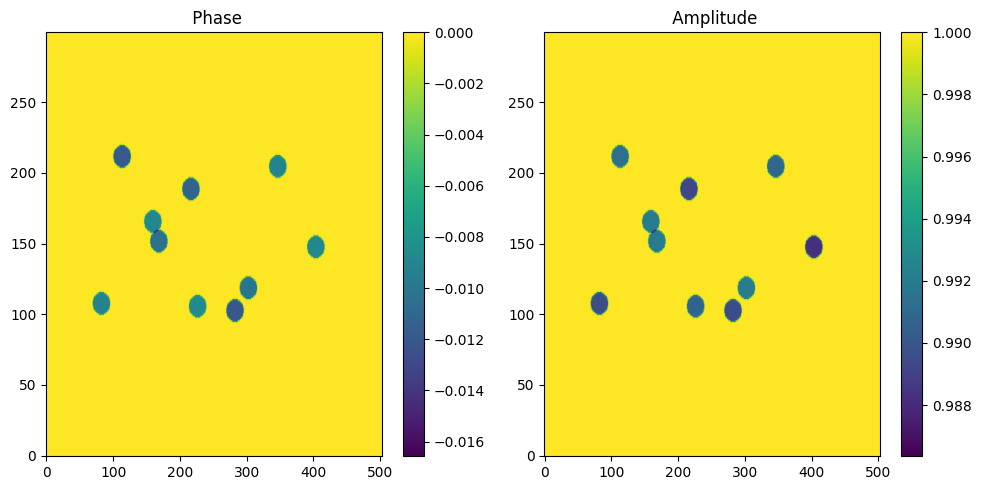

In [4]:
# --- Create the SimulationConfig object ---
# Defines scan path, probe parameters, discretization, 
# object domain.
# Solver parameters are defined in the solver classes.
sim_config = SimulationConfig(
    # Probe parameters
    probe_type=probe_type,
    wave_length=wavelength,
    probe_diameter=probe_diameter,
    probe_focus=probe_focus,
    #probe_angles=probe_angles,

    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=True,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,

    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0, # 1.0 for free space

    # Logging and results
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()
print("Padding/Overlap:", simulation_space.nx - simulation_space.min_nx)

# --- Create a Simultated Ptycho Object ---
ptycho_object = create_ptycho_object(simulation_space)


# Add 6 spheres of varying positions
# Base refractive index offsets
delta = 0.01 # real part (phase shift)
beta = 0.01 # complex part (absorption)
delta_var = 0.20   # ±20% variation in phase shift
beta_var  = 0.20   # ±20% variation in absorption

gaussian_blur = 0.5
common_side_length_factor = 0.05
common_depth_factor = 0.05
num_circles = 10
random_seed = 5

np.random.seed(random_seed)

# Generate random (x,z) centers
x_centers = np.random.uniform(0.25, 0.75, size=num_circles)
z_centers = np.random.uniform(0.1, 0.9, size=num_circles)

for cx, cz in zip(x_centers, z_centers):

    # Randomize refractive index perturbation per circle
    delta_rand = delta * (1 + delta_var * (np.random.rand() - 0.5) * 2)
    beta_rand  = beta  * (1 + beta_var  * (np.random.rand() - 0.5) * 2)

    refractive_index_perturbation = -delta_rand - 1j * beta_rand

    ptycho_object.add_object(
        'circle',
        refractive_index_perturbation,
        side_length_factor=common_side_length_factor,
        centre_factor=(cx, cz), # normalized coordinates
        depth_factor=common_depth_factor,
        gaussian_blur=gaussian_blur)
    
ptycho_object.build_field()

# --- Visualize the True Object ---
simulation_space.viewer.plot_two_panels(ptycho_object.n_true, view="phase_amp")


# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes = create_ptycho_probes(simulation_space)

### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [5]:
# Solve Full Space Space, Iterative
# --- Enumerated configuration types ---
bc_type = BoundaryType.DIRICHLET

# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe = PWEIterativeLUSolver(simulation_space,
                                ptycho_object,
                                ptycho_probes,
                                bc_type=bc_type)
# forward_model_pwe = PWEFullPinTSolver(simulation_space,
#                                 ptycho_object,
#                                 ptycho_probes,
#                                 bc_type=bc_type,
#                                 alpha=1e-3,
#                                 atol=1e-3)


# Iterative solution
u_pwe = forward_model_pwe.solve()
time_end = time.time()
print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
exit_waves_pwe = forward_model_pwe.get_exit_waves(u_pwe)
intensities_pwe_noisy = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=True)
intensities_pwe = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=False)

ValueError: inconsistent shapes

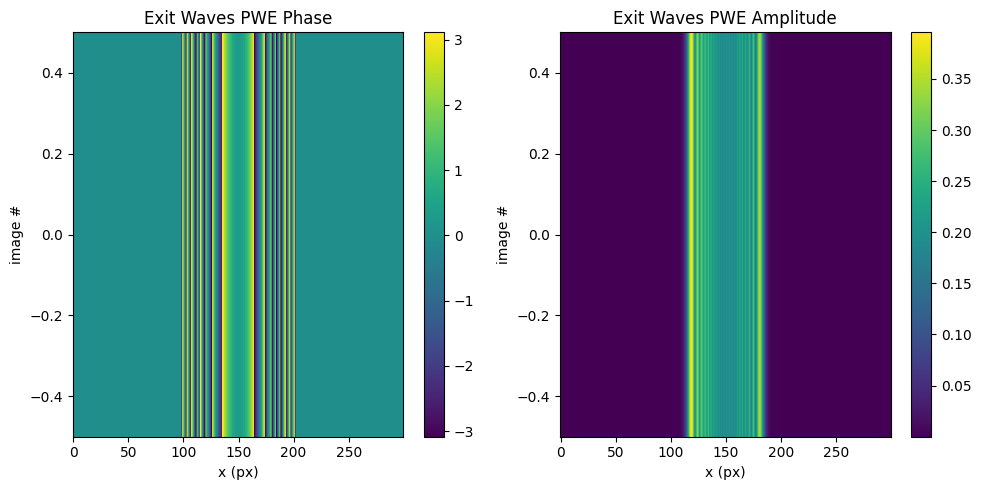

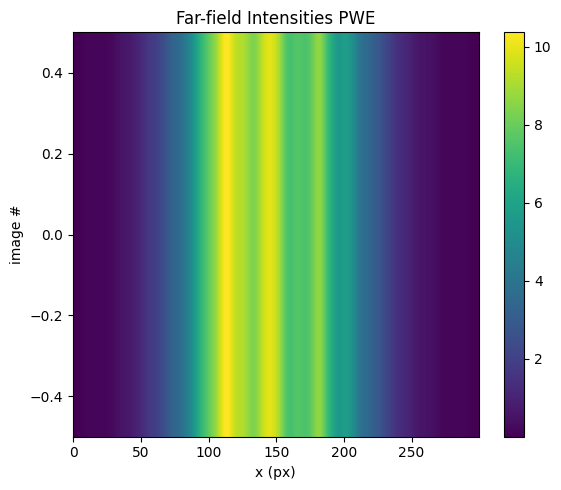

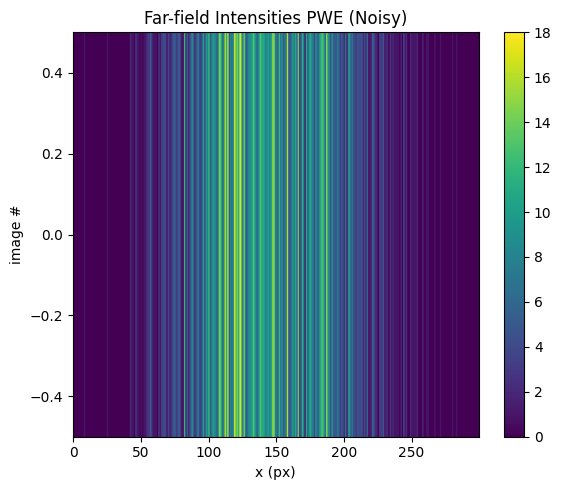

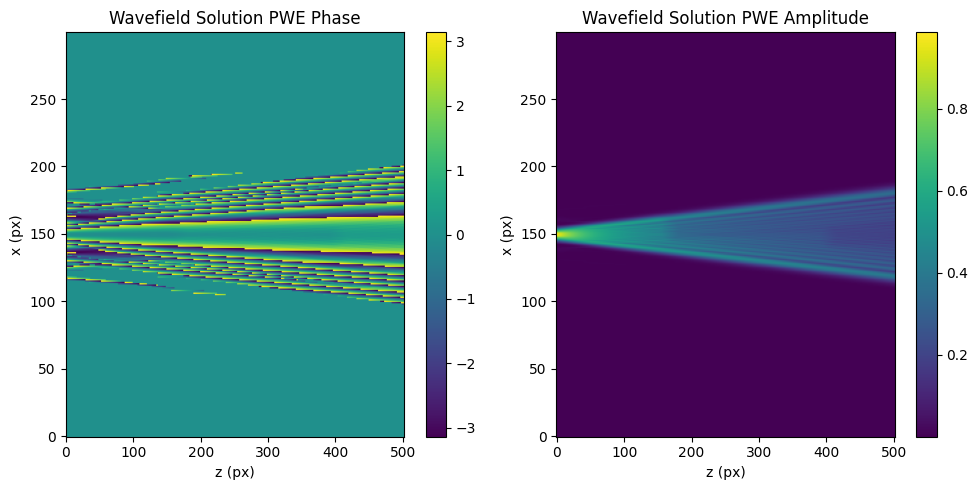

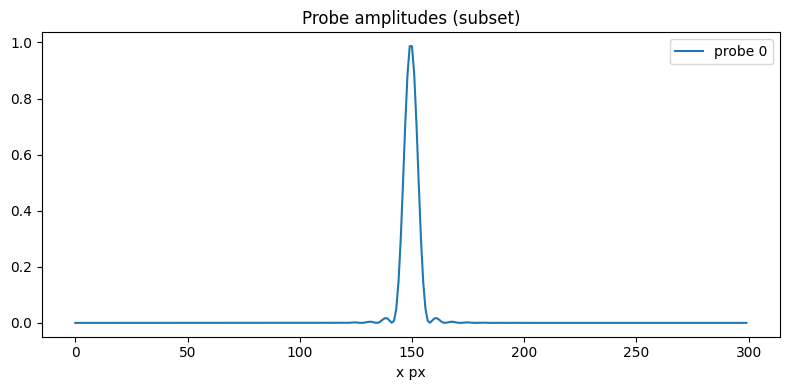

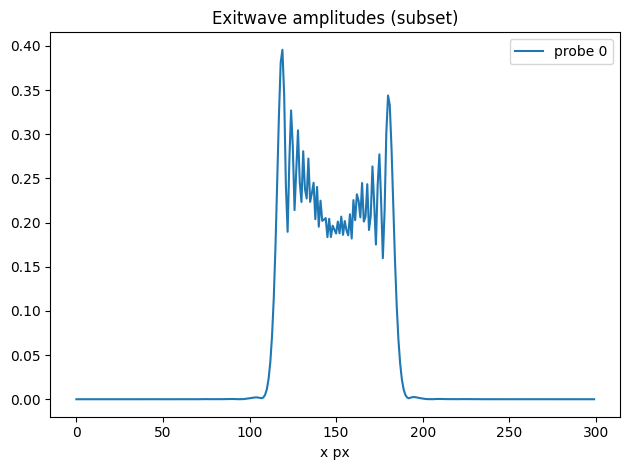

In [ ]:
simulation_space.viewer.plot_two_panels(exit_waves_pwe,
                                        view="phase_amp", 
                                        title="Exit Waves PWE",
                                        xlabel="x (px)",
                                        ylabel="image #")

simulation_space.viewer.plot_single_panel(np.fft.fftshift(intensities_pwe),
                                        title="Far-field Intensities PWE",
                                        xlabel="x (px)",
                                        ylabel="image #")

simulation_space.viewer.plot_single_panel(np.fft.fftshift(intensities_pwe_noisy),
                                        title="Far-field Intensities PWE (Noisy)",
                                        xlabel="x (px)",
                                        ylabel="image #")

# Select Centre Probe
centre_probe_pwe = u_pwe[simulation_space.num_projections//2,
                         simulation_space.num_angles//2,
                         simulation_space.num_probes//2, ...]
simulation_space.viewer.plot_two_panels(centre_probe_pwe,
                                        view="phase_amp", 
                                        title="Wavefield Solution PWE",
                                        xlabel="z (px)",
                                        ylabel="x (px)")

# plt.plot(range(simulation_space.effective_nx), u_pwe[0,0,simulation_space.num_probes//2, :, simulation_space.nz//2])
# plt.show()

plt.figure(figsize=(8,4))
plot_num_probes = min(10,simulation_space.total_scans)#simulation_space.num_probes
probe_indices = np.linspace(0, simulation_space.total_scans-1, plot_num_probes, dtype=int)

u_pwe_flat = u_pwe.reshape((simulation_space.total_scans,*u_pwe.shape[-2:]))
for p in probe_indices:
    plt.plot(range(simulation_space.effective_nx), np.abs(u_pwe_flat[p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x px"); plt.legend(); 
plt.tight_layout(); plt.show()

for p in probe_indices:
    plt.plot(range(simulation_space.effective_nx), np.abs(u_pwe_flat[p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x px"); plt.legend(); 
plt.tight_layout(); plt.show()


### 6. Inverse Problem Assuming Phase
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [ ]:
# --- Reconstruction data ---
complex_data = exit_waves_pwe

In [ ]:
# Create MS Simulation Space
nz = 50

# --- Create the SimulationConfig object ---
sim_config_ms = SimulationConfig(
    # Probe parameters
    probe_type=probe_type,
    wave_length=wavelength,
    probe_diameter=probe_diameter,
    probe_focus=probe_focus,

    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=solve_reduced_domain,
    nz=nz,
    #points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,

    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0, # 1.0 for free space

    # Logging and results
    results_dir="./results",
    use_logging=True
)
simulation_space_ms = create_simulation_space(sim_config_ms)
simulation_space_ms.summarize()


2025-11-12 17:20:46,426 - INFO - === Scan Summary (Continuous) ===
2025-11-12 17:20:46,428 - INFO -   Sample space (x-range): 1.100e-04 m
2025-11-12 17:20:46,430 - INFO -   Sample space (z-range): 4.000e-05 m
2025-11-12 17:20:46,432 - INFO -   Sample Pixels:          301
2025-11-12 17:20:46,434 - INFO -   Number of scan points:  1
2025-11-12 17:20:46,436 - INFO -   Steps in z:             50
2025-11-12 17:20:46,437 - INFO -   Probe diameter:         5.000e-06 m
2025-11-12 17:20:46,438 - INFO -   Probe Pixels:          13 px


In [ ]:
recon_ms = ReconstructorMS(simulation_space_ms, complex_data.squeeze(), phase_retrieval=False, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="real_img",title="Reconstructed Transmission Function Object MS")
# --- Visualize the True Object ---
simulation_space_ms.viewer.plot_residual(residual_ms)

ValueError: could not broadcast input array from shape (301,) into shape (300,)

Initializing Least Squares Solver...
Iteration 1/10
    RMSE: 0.02769925135806724
    Iteration 1 took 10.76 seconds.
Iteration 2/10
    RMSE: 0.02498965357038496
    Iteration 2 took 10.39 seconds.
Iteration 3/10
    RMSE: 0.022669278715818236
    Iteration 3 took 10.54 seconds.
Iteration 4/10
    RMSE: 0.020609639267385748
    Iteration 4 took 9.87 seconds.
Iteration 5/10
    RMSE: 0.01878319105491768
    Iteration 5 took 9.79 seconds.
Iteration 6/10
    RMSE: 0.0171650643817238
    Iteration 6 took 9.65 seconds.
Iteration 7/10
    RMSE: 0.015745751563305287
    Iteration 7 took 18.41 seconds.
Iteration 8/10
    RMSE: 0.0145722284629063
    Iteration 8 took 8.84 seconds.
Iteration 9/10
    RMSE: 0.013450623076358246
    Iteration 9 took 8.43 seconds.
Iteration 10/10
    RMSE: 0.01240349010277329
    Iteration 10 took 8.57 seconds.
Reconstruction time: 105.28 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

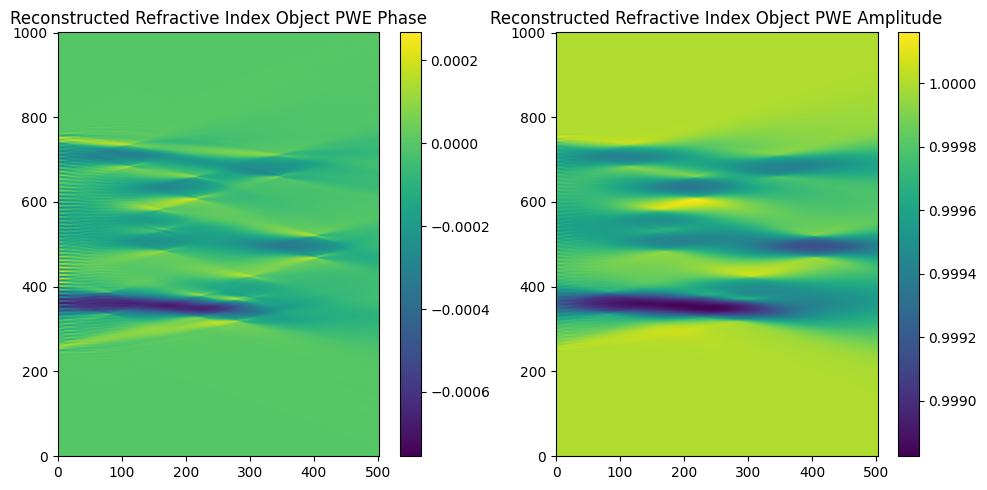

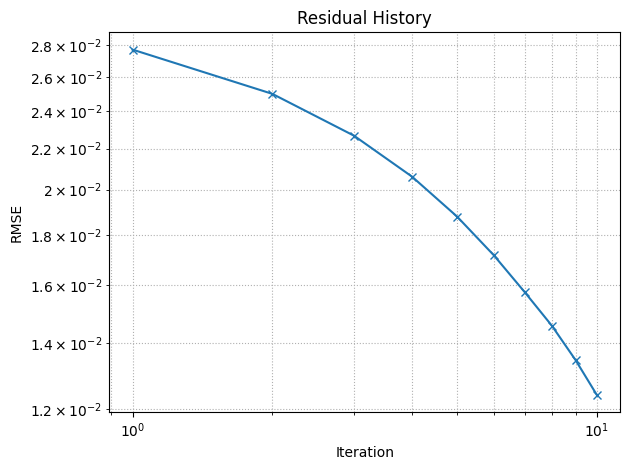

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, complex_data, phase_retrieval=False, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp",title="Reconstructed Refractive Index Object PWE")
simulation_space.viewer.plot_residual(residual_pwe)

## Phase Retrieval

In [ ]:
# --- Reconstruction data ---
data = intensities_pwe

Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 0.0035490736342157544
[Iter 002] Mean Loss = 0.0033915867621054727
[Iter 003] Mean Loss = 0.0033216453508669304
[Iter 004] Mean Loss = 0.003279764138891371
[Iter 005] Mean Loss = 0.0032513314558924008
[Iter 006] Mean Loss = 0.0032306165076001567
[Iter 007] Mean Loss = 0.00321482235901535
[Iter 008] Mean Loss = 0.003202392697322399
[Iter 009] Mean Loss = 0.00319238133359193
[Iter 010] Mean Loss = 0.0031841748457274023
Reconstruction time: 3.28 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

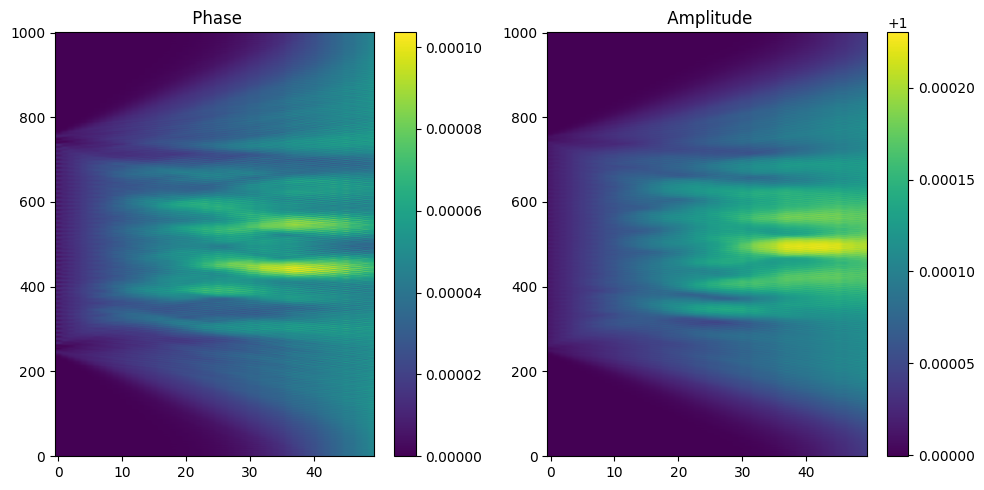

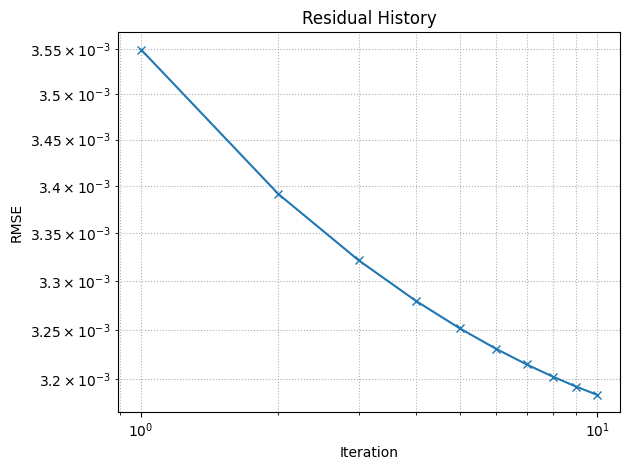

In [ ]:

recon_ms = ReconstructorMS(simulation_space_ms, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

Initializing Least Squares Solver...
Iteration 1/10
    RMSE: 0.0074686111830496536
    Iteration 1 took 11.50 seconds.
Iteration 2/10
    RMSE: 0.0068979876690977516
    Iteration 2 took 15.83 seconds.
Iteration 3/10
    RMSE: 0.006394538528231156
    Iteration 3 took 22.31 seconds.
Iteration 4/10
    RMSE: 0.00591901694981922
    Iteration 4 took 18.12 seconds.
Iteration 5/10
    RMSE: 0.00546971463968302
    Iteration 5 took 21.23 seconds.
Iteration 6/10
    RMSE: 0.005043971340164901
    Iteration 6 took 17.59 seconds.
Iteration 7/10
    RMSE: 0.004639690386470769
    Iteration 7 took 17.30 seconds.
Iteration 8/10
    RMSE: 0.0042556797668760185
    Iteration 8 took 15.03 seconds.
Iteration 9/10
    RMSE: 0.003892489628942595
    Iteration 9 took 12.26 seconds.
Iteration 10/10
    RMSE: 0.00355394532550485
    Iteration 10 took 14.92 seconds.
Reconstruction time: 166.10 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

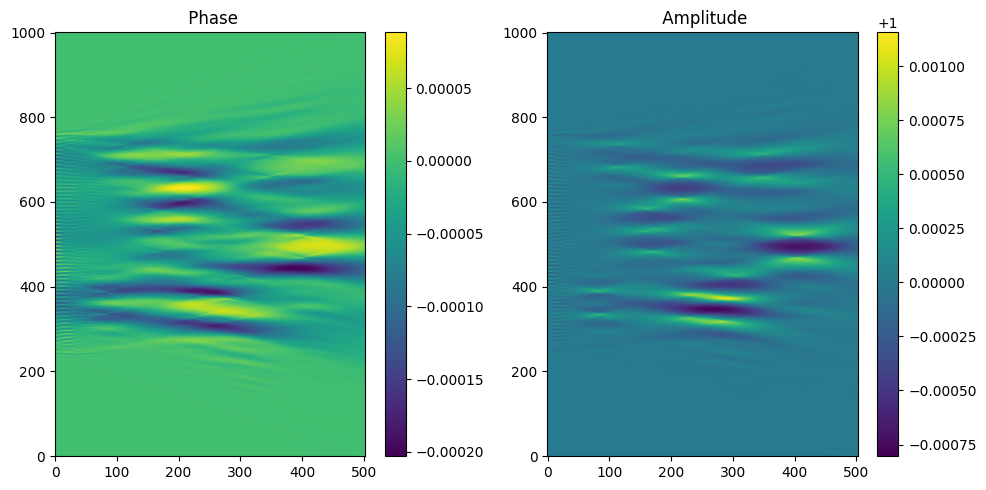

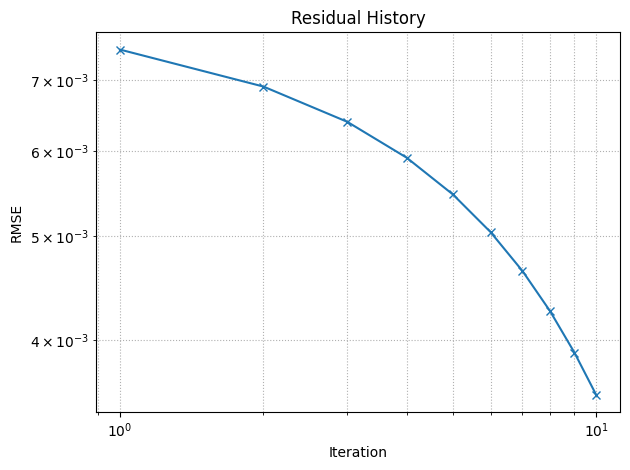

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space.viewer.plot_residual(residual_pwe)

# Phase Retrieval (noisy data)

In [ ]:
rng = np.random.default_rng(seed=42)

data = rng.poisson(intensities_pwe) 


Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 0.008910640235134193
[Iter 002] Mean Loss = 0.008737317236438577
[Iter 003] Mean Loss = 0.00865880775504721
[Iter 004] Mean Loss = 0.008610975737826869
[Iter 005] Mean Loss = 0.008577962989881454
[Iter 006] Mean Loss = 0.0085535167714328
[Iter 007] Mean Loss = 0.008534570444247089
[Iter 008] Mean Loss = 0.008519409684117902
[Iter 009] Mean Loss = 0.008506987560663594
[Iter 010] Mean Loss = 0.008496622400708033
Reconstruction time: 6.88 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

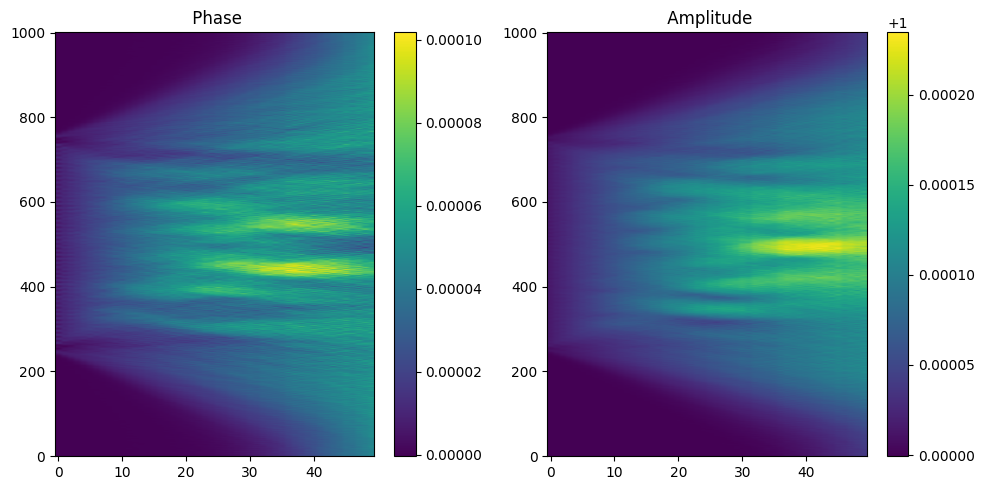

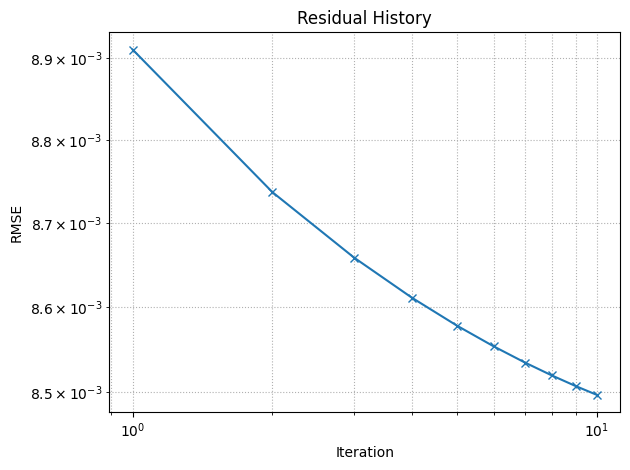

In [ ]:
recon_ms = ReconstructorMS(simulation_space_ms, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

Initializing Least Squares Solver...
Iteration 1/10
    RMSE: 0.012455716540185572
    Iteration 1 took 17.65 seconds.
Iteration 2/10
    RMSE: 0.012140176319884677
    Iteration 2 took 15.82 seconds.
Iteration 3/10
    RMSE: 0.011882160492893753
    Iteration 3 took 12.56 seconds.
Iteration 4/10
    RMSE: 0.01165769523383952
    Iteration 4 took 13.93 seconds.
Iteration 5/10
    RMSE: 0.011461966091121024
    Iteration 5 took 22.26 seconds.
Iteration 6/10
    RMSE: 0.011290527580145041
    Iteration 6 took 19.96 seconds.
Iteration 7/10
    RMSE: 0.011139645028595302
    Iteration 7 took 16.79 seconds.
Iteration 8/10
    RMSE: 0.011006221688002275
    Iteration 8 took 18.86 seconds.
Iteration 9/10
    RMSE: 0.010887769191723708
    Iteration 9 took 22.68 seconds.
Iteration 10/10
    RMSE: 0.010782402516875306
    Iteration 10 took 16.58 seconds.
Reconstruction time: 177.11 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

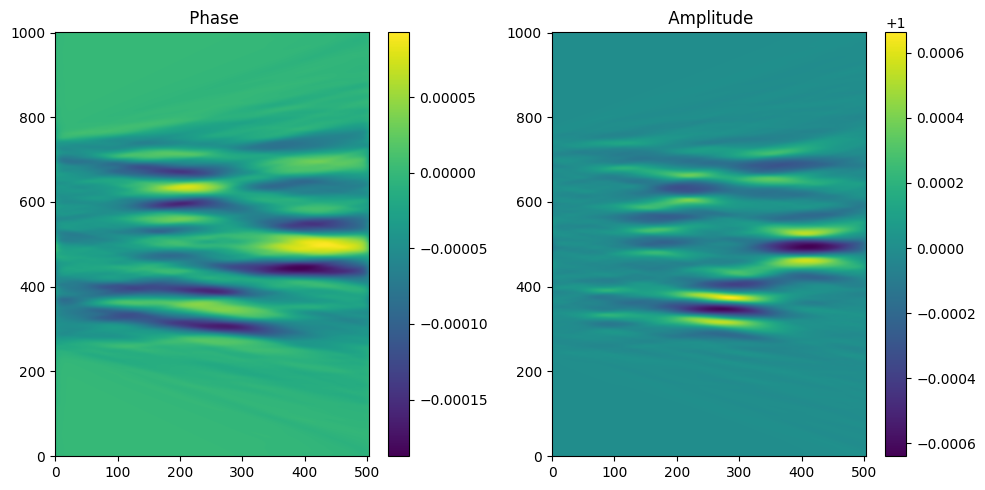

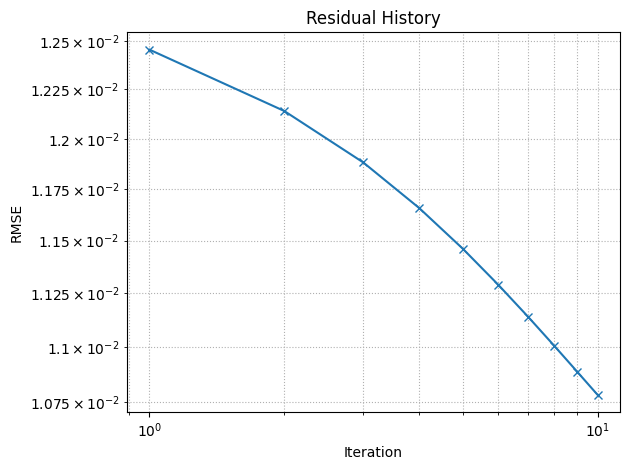

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10,tv_lambda_amp=0.5, low_pass_sigma_phase=0.05)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
colorbar_limits_left = (np.min(np.angle(ptycho_object.n_true)), np.max(np.angle(ptycho_object.n_true)))
colorbar_limits_right = (np.min(np.abs(ptycho_object.n_true)), np.max(np.abs(ptycho_object.n_true)))
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")#,colorbar_limits_left=colorbar_limits_left,colorbar_limits_right=colorbar_limits_right)
simulation_space.viewer.plot_residual(residual_pwe)

(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': 'True Refractive Index Object Phase'}>,
        <Axes: title={'center': 'True Refractive Index Object Amplitude'}>],
       dtype=object))

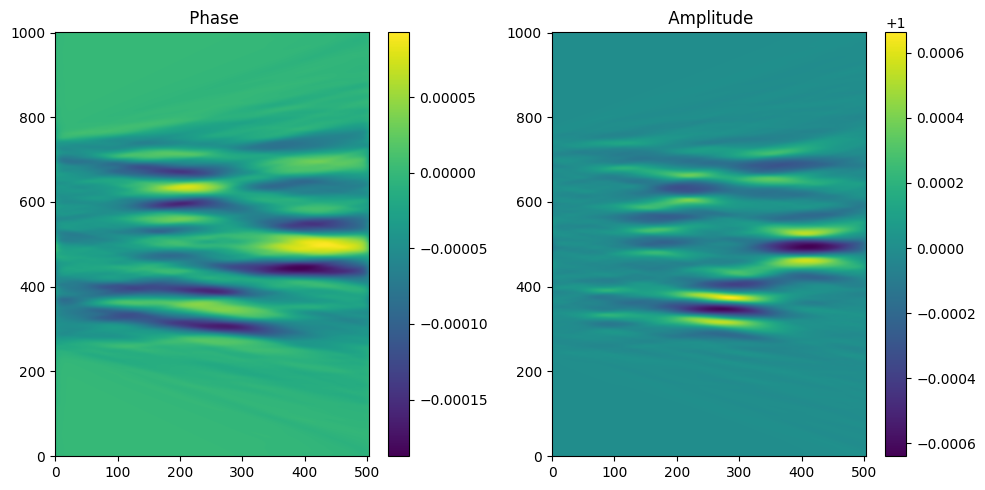

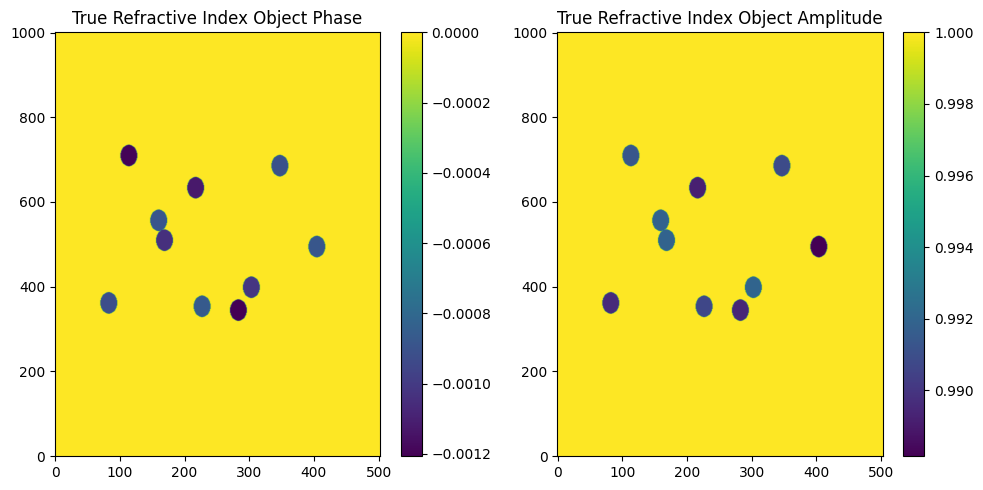

In [ ]:
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space.viewer.plot_two_panels(ptycho_object.n_true, view="phase_amp",title="True Refractive Index Object")